In [1]:
import connectorx as cx
import pandas as pd
import numpy as np
import os
import duckdb
from datetime import datetime
import glob
import multiprocessing as mp
from functools import partial
import time

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [1]:
df = pd.read_parquet("/data/home/lexuanchen/.conda/envs/Order_Improvement/factors/percent_minute_price_divergence/20210518.parquet")
df.head()

NameError: name 'pd' is not defined

In [6]:
df = pd.read_parquet("/data/home/lexuanchen/.conda/envs/Order_Improvement/factors/percent_minute_price_divergence/20210518.parquet")
df['datetime'] = pd.to_datetime(df['order_minute'])
df['start_time'] = df['datetime'].dt.hour * 100 + df['datetime'].dt.minute


minute_df = df[['date','security_code','start_time','bid_price_divergence_p01p99','ask_price_divergence_p01p99']]
minute_df = minute_df.rename(columns={'date': 'trading_day'})
minute_df['start_time'] = minute_df['start_time'].astype(int)
minute_df['security_code'] = minute_df['security_code'].astype(str)
minute_df['trading_day'] = pd.to_datetime(minute_df['trading_day'])


minute_ret = pd.read_parquet("/data/cephfs/minute/one_minute/20210518.parquet")
minute_ret = minute_ret[['security_code','trading_day','start_time','minute_return']]
minute_ret['start_time'] = minute_ret['start_time'].astype(int)
minute_ret['security_code'] = minute_ret['security_code'].astype(str)
minute_ret['trading_day'] = pd.to_datetime(minute_ret['trading_day'])


merged_minute = pd.merge(
    minute_df,
    minute_ret,
    on=['security_code','trading_day','start_time'],
    how='outer'
)


df_clean = merged_minute.dropna(subset=['ask_price_divergence_p01p99','bid_price_divergence_p01p99', 'minute_return'])
df_clean = df_clean[ df_clean['minute_return'] != 0]

df_clean.head()

,trading_day,security_code,start_time,bid_price_divergence_p01p99,ask_price_divergence_p01p99,minute_return
10,2021-05-18,000001,930,0.016384,0.018706,-0.014675
11,2021-05-18,000001,931,0.012017,0.018849,-0.000426
12,2021-05-18,000001,932,0.011531,0.029098,-0.001277
13,2021-05-18,000001,933,0.006769,0.015459,0.005968
14,2021-05-18,000001,934,0.008858,0.022534,0.003390


In [2]:
import random

base_path = "/data/home/lexuanchen/.conda/envs/Order_Improvement/factors/Minute_Ret_and_Minute_Percent_Order_Price_Divergence"

all_files = glob.glob(os.path.join(base_path, "*.parquet"))

selected_files = random.sample(all_files, 15)

dfs = []
for file in selected_files:
    try:
        df = pd.read_parquet(file)
        # 添加日期列，从文件名中提取日期
        
        dfs.append(df)
        print(f"成功读取文件: {os.path.basename(file)}, 行数: {len(df)}")
    except Exception as e:
        print(f"读取文件 {os.path.basename(file)} 时出错: {e}")

# 合并所有数据框
if dfs:
    df_day = pd.concat(dfs, ignore_index=True)
    print(f"\n合并完成，总行数: {len(df_day)}")

成功读取文件: 20250124.parquet, 行数: 1277983
成功读取文件: 20240312.parquet, 行数: 1274390
成功读取文件: 20201215.parquet, 行数: 1020889
成功读取文件: 20220321.parquet, 行数: 1163190
成功读取文件: 20200604.parquet, 行数: 953926
成功读取文件: 20200316.parquet, 行数: 944091
成功读取文件: 20211027.parquet, 行数: 1126516
成功读取文件: 20220113.parquet, 行数: 1149943
成功读取文件: 20221229.parquet, 行数: 1221894
成功读取文件: 20190326.parquet, 行数: 890788
成功读取文件: 20240902.parquet, 行数: 1269607
成功读取文件: 20231101.parquet, 行数: 1266557
成功读取文件: 20201117.parquet, 行数: 1014716
成功读取文件: 20250423.parquet, 行数: 1281430
成功读取文件: 20230223.parquet, 行数: 1228238

合并完成，总行数: 17084158


In [3]:
df_day.head()

,trading_day,security_code,start_time,bid_price_divergence_p01p99,ask_price_divergence_p01p99,minute_return
0,2025-01-24,000001,915,0.027187,0.026142,NaN
1,2025-01-24,000001,916,0.045077,0.038948,NaN
2,2025-01-24,000001,917,0.009343,0.024054,NaN
3,2025-01-24,000001,918,0.009462,0.024233,NaN
4,2025-01-24,000001,919,0.014771,0.059674,NaN


2019-01-02数据样本量: 10357359
证券数量: 5334

基本统计信息:
       ask_price_divergence_p01p99  bid_price_divergence_p01p99  minute_return
count                 1.035736e+07                 1.035736e+07   1.035736e+07
mean                 -9.310565e-03                -4.450180e-03  -2.813633e-05
std                   1.446907e-02                 1.806537e-02   2.740264e-03
min                  -3.422215e+00                -4.447147e+00  -1.788462e-01
25%                  -1.249581e-02                -5.293595e-03  -1.494768e-03
50%                  -4.007986e-03                -2.569473e-03  -3.335001e-04
75%                  -1.198005e-03                -1.146330e-03   1.404494e-03
max                  -0.000000e+00                -0.000000e+00   2.677980e-01

相关性矩阵:
                             ask_price_divergence_p01p99  minute_return
ask_price_divergence_p01p99                     1.000000      -0.055154
minute_return                                  -0.055154       1.000000

相关性矩阵:
           

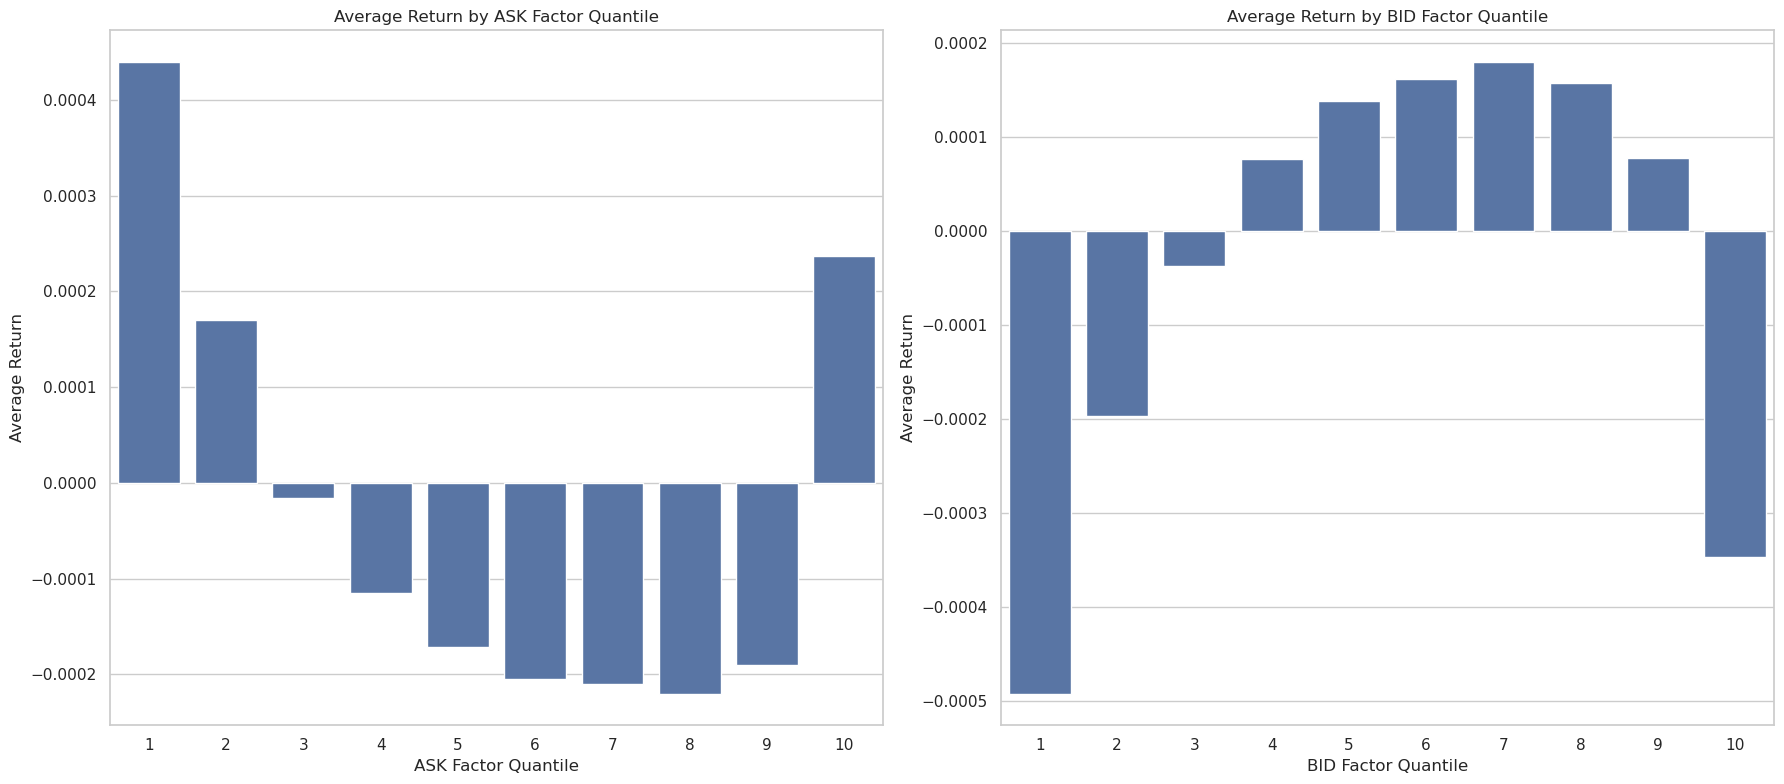

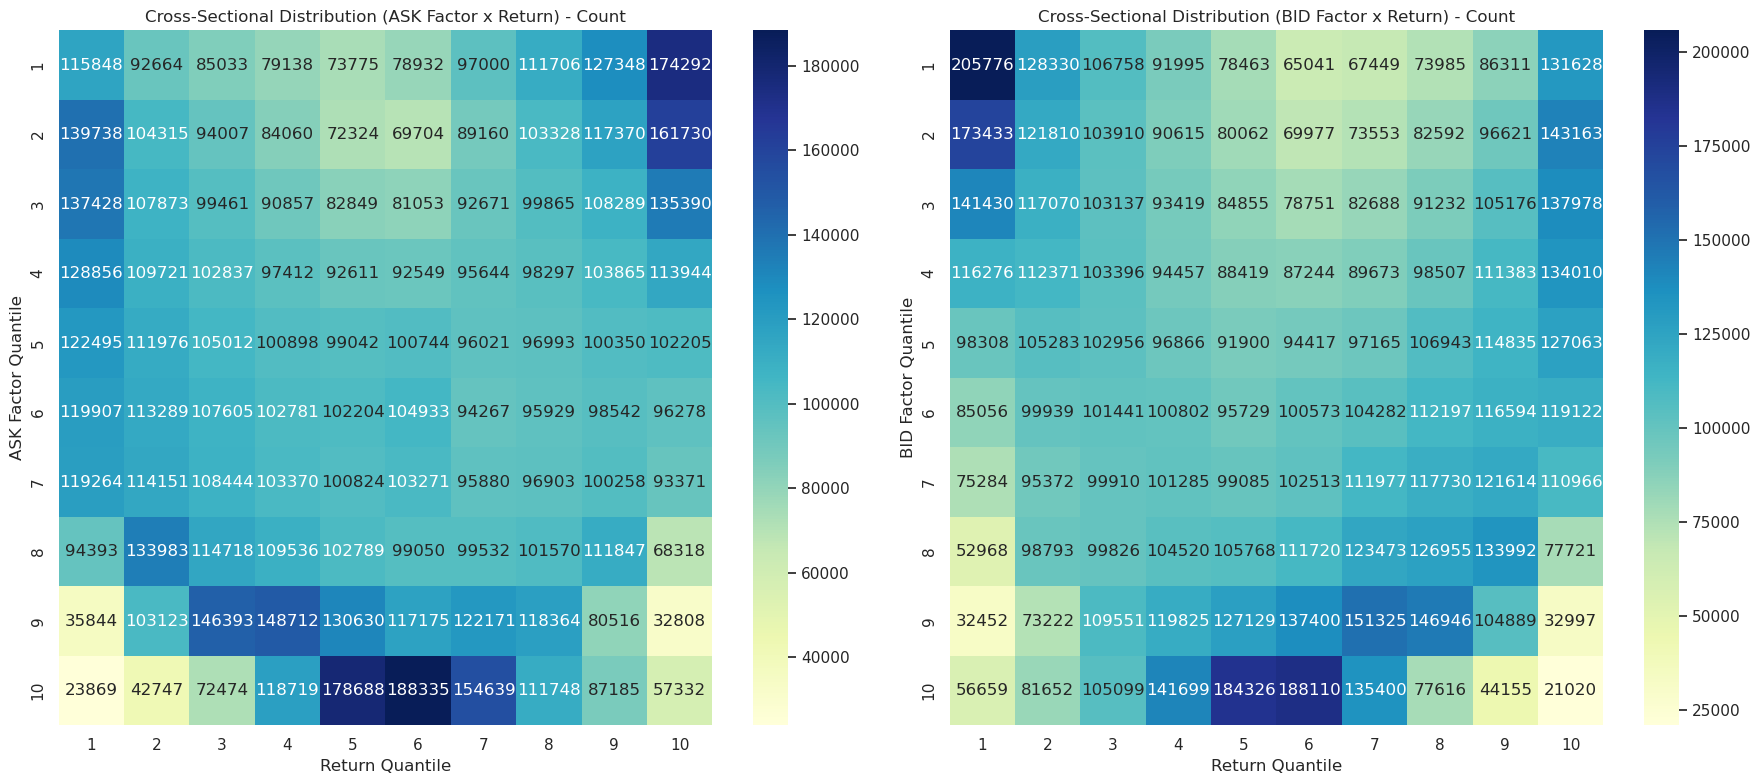

In [4]:
# date = '2021-05-18'
# df_day = df_clean[df_clean['trading_day'] == date].copy()

df_day = df_day.dropna(subset=['ask_price_divergence_p01p99','bid_price_divergence_p01p99', 'minute_return'])
df_day = df_day[df_day['minute_return'] != 0]

df_day['ask_price_divergence_p01p99'] = - df_day['ask_price_divergence_p01p99']

df_day['bid_price_divergence_p01p99'] = - df_day['bid_price_divergence_p01p99']

print(f"2019-01-02数据样本量: {len(df_day)}")
print(f"证券数量: {df_day['security_code'].nunique()}")

# 基本统计信息
print("\n基本统计信息:")
print(df_day[['ask_price_divergence_p01p99','bid_price_divergence_p01p99', 'minute_return']].describe())

# 计算相关性
corr1 = df_day[['ask_price_divergence_p01p99', 'minute_return']].corr()
print("\n相关性矩阵:")
print(corr1)

corr2 = df_day[['bid_price_divergence_p01p99', 'minute_return']].corr()
print("\n相关性矩阵:")
print(corr2)

# 1. 分别按因子值和收益率进行5分组
df_day['ask_factor_quantile'] = pd.qcut(df_day['ask_price_divergence_p01p99'], 10, labels=False) + 1
df_day['bid_factor_quantile'] = pd.qcut(df_day['bid_price_divergence_p01p99'], 10, labels=False) + 1
df_day['return_quantile'] = pd.qcut(df_day['minute_return'], 10, labels=False) + 1

# 2. 创建10x10交叉分组表
cross_table1 = pd.crosstab(
    df_day['ask_factor_quantile'], 
    df_day['return_quantile']
)  

print("\nASK交叉分组表 :")
print(cross_table1)

cross_table2 = pd.crosstab(
    df_day['bid_factor_quantile'], 
    df_day['return_quantile']
)  

print("\nBID交叉分组表 :")
print(cross_table2)


# 3. 计算每个因子分组的平均收益率
ask_factor_returns = df_day.groupby('ask_factor_quantile')['minute_return'].agg(['mean', 'std', 'count'])
ask_factor_returns['t_stat'] = ask_factor_returns['mean'] / (ask_factor_returns['std'] / np.sqrt(ask_factor_returns['count']))
print("\nASK因子分组的平均收益率:")
print(ask_factor_returns)

# 4. 计算最高分组与最低分组的收益率差异
ask_top_minus_bottom = ask_factor_returns.loc[5, 'mean'] - ask_factor_returns.loc[1, 'mean']
print(f"\n卖方最高分组与最低分组的收益率差异: {ask_top_minus_bottom:.6f}")


# 3. 计算每个因子分组的平均收益率
bid_factor_returns = df_day.groupby('bid_factor_quantile')['minute_return'].agg(['mean', 'std', 'count'])
bid_factor_returns['t_stat'] = bid_factor_returns['mean'] / (bid_factor_returns['std'] / np.sqrt(bid_factor_returns['count']))
print("\nBID因子分组的平均收益率:")
print(bid_factor_returns)

# 4. 计算最高分组与最低分组的收益率差异
bid_top_minus_bottom = bid_factor_returns.loc[5, 'mean'] - bid_factor_returns.loc[1, 'mean']
print(f"\n买方最高分组与最低分组的收益率差异: {bid_top_minus_bottom:.6f}")



# 5. 可视化

# 设置图表风格
sns.set(style="whitegrid")

plt.figure(figsize=(18, 8))
# 5.3 因子分组平均收益率
plt.subplot(1, 2, 1)
sns.barplot(x=ask_factor_returns.index, y=ask_factor_returns['mean'])
plt.title('Average Return by ASK Factor Quantile')
plt.xlabel('ASK Factor Quantile')
plt.ylabel('Average Return')

plt.subplot(1, 2, 2)
sns.barplot(x=bid_factor_returns.index, y=bid_factor_returns['mean'])
plt.title('Average Return by BID Factor Quantile')
plt.xlabel('BID Factor Quantile')
plt.ylabel('Average Return')

plt.tight_layout()
plt.show()

# 5.4 交叉分组热力图
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
sns.heatmap(cross_table1, annot=True, cmap="YlGnBu", fmt='d')
plt.title('Cross-Sectional Distribution (ASK Factor x Return) - Count')
plt.xlabel('Return Quantile')
plt.ylabel('ASK Factor Quantile')

plt.subplot(1, 2, 2)
sns.heatmap(cross_table2, annot=True, cmap="YlGnBu", fmt='d')
plt.title('Cross-Sectional Distribution (BID Factor x Return) - Count')
plt.xlabel('Return Quantile')
plt.ylabel('BID Factor Quantile')

plt.tight_layout()
# plt.savefig(f'factor_analysis_{date}.png', dpi=300)
plt.show()

In [14]:
def derive_daily_minute_combined(trading_date):
    
    date_str = pd.to_datetime(trading_date).strftime('%Y%m%d')
    factor_dir = f"/data/home/lexuanchen/.conda/envs/Order_Improvement/factors/percent_minute_price_divergence/{date_str}.parquet"
    one_min_dir = f"/data/cephfs/minute/one_minute/{date_str}.parquet"

    df = pd.read_parquet(factor_dir)
    minute_ret = pd.read_parquet(one_min_dir)

    df['datetime'] = pd.to_datetime(df['order_minute'])
    df['start_time'] = df['datetime'].dt.hour * 100 + df['datetime'].dt.minute
    df['trading_day'] = pd.to_datetime(df['date'])

    minute_df = df[['trading_day','security_code','start_time','bid_price_divergence_p01p99','ask_price_divergence_p01p99']]

    minute_ret = minute_ret[['security_code','trading_day','start_time','minute_return']]
    minute_ret['start_time'] = minute_ret['start_time'].astype(int)
    minute_ret['security_code'] = minute_ret['security_code'].astype(str)
    minute_ret['trading_day'] = pd.to_datetime(minute_ret['trading_day'])


    minute_df = minute_df.rename(columns={'date': 'trading_day'})
    minute_df['start_time'] = minute_df['start_time'].astype(int)
    minute_df['security_code'] = minute_df['security_code'].astype(str)
    minute_df['trading_day'] = pd.to_datetime(minute_df['trading_day'])

    merged_minute = pd.merge(
        minute_df,
        minute_ret,
        on=['security_code','trading_day','start_time'],
        how='outer'
    )


    return merged_minute

    

In [10]:
def process_single_date(trading_date, factor_name):
    
    """处理单个交易日的函数"""
   
    date_str = trading_date.strftime('%Y%m%d')
    output_dir = f"./factors/Minute_Ret_and_{factor_name}"
    file_path = f"{output_dir}/{date_str}.parquet"
    
    # 如果文件已存在，跳过处理
    if os.path.exists(file_path):
        print(f"文件已存在，跳过: {file_path}")
        return date_str, True, "已存在"
    
    # 检查原始数据文件是否存在
    data_file = f"/data/cephfs/minute/one_minute/{date_str}.parquet"
    if not os.path.exists(data_file):
        print(f"跳过日期 {date_str}: 原始数据文件不存在")
        return date_str, False, "数据文件不存在"
    
    try:
        daily_factor_df = derive_daily_minute_combined(trading_date)
        

        daily_factor_df.to_parquet(file_path, index=False)
        print(f"已生成因子文件: {file_path}")
        return date_str, True, "成功"
        
    except Exception as e:
        error_msg = str(e)
        print(f"处理日期 {date_str} 时出错: {error_msg}")
        return date_str, False, error_msg


def derive_daily_factor(start_date, end_date, factor_name, num_processes=30):
    start_time = time.time()
    
    trading_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # 创建输出目录
    output_dir = f"./factors/Minute_Ret_and_{factor_name}"
    os.makedirs(output_dir, exist_ok=True)
    
    # 创建进程池
    pool = mp.Pool(processes=num_processes)
    
    # 创建带有固定参数的处理函数
    process_date_with_args = partial(process_single_date, factor_name=factor_name)
    
    # 提交所有任务到进程池并获取结果
    print(f"开始使用 {num_processes} 个进程并行处理 {len(trading_dates)} 个交易日...")
    results = pool.map(process_date_with_args, trading_dates)
    
    # 关闭进程池
    pool.close()
    pool.join()
    
    # 分析处理结果
    processed_dates = [date_str for date_str, success, _ in results if success]
    skipped_dates = [date_str for date_str, success, _ in results if not success]
    
    # 打印处理结果摘要
    print(f"\n处理完成:")
    print(f"成功处理 {len(processed_dates)} 个日期")
    print(f"跳过 {len(skipped_dates)} 个日期")

    return output_dir


In [11]:
def main():

    start_date = '2019-01-01'
    end_date = '2025-05-31'

    factor_name = "Minute_Percent_Order_Price_Divergence"

    factor_dir = derive_daily_factor (start_date, end_date, factor_name)
    print(f"所有因子文件已生成在目录: {factor_dir}")

main()

跳过日期 20190101: 原始数据文件不存在跳过日期 20190210: 原始数据文件不存在跳过日期 20190302: 原始数据文件不存在跳过日期 20190501: 原始数据文件不存在跳过日期 20190720: 原始数据文件不存在跳过日期 20190630: 原始数据文件不存在跳过日期 20191207: 原始数据文件不存在跳过日期 20191117: 原始数据文件不存在跳过日期 20200405: 原始数据文件不存在跳过日期 20200425: 原始数据文件不存在


跳过日期 20190303: 原始数据文件不存在
跳过日期 20190502: 原始数据文件不存在



跳过日期 20190721: 原始数据文件不存在跳过日期 20190503: 原始数据文件不存在





跳过日期 20191208: 原始数据文件不存在跳过日期 20200426: 原始数据文件不存在跳过日期 20190504: 原始数据文件不存在跳过日期 20200406: 原始数据文件不存在



跳过日期 20190505: 原始数据文件不存在
开始使用 30 个进程并行处理 2343 个交易日...
已生成因子文件: ./factors/Minute_Ret_and_Minute_Percent_Order_Price_Divergence/20190102.parquet
已生成因子文件: ./factors/Minute_Ret_and_Minute_Percent_Order_Price_Divergence/20190610.parquet
已生成因子文件: ./factors/Minute_Ret_and_Minute_Percent_Order_Price_Divergence/20191028.parquet
已生成因子文件: ./factors/Minute_Ret_and_Minute_Percent_Order_Price_Divergence/20191118.parquet
已生成因子文件: ./factors/Minute_Ret_and_Minute_Percent_Order_Price_Divergence/20190722.parquet
已生成因子文件: ./factors/Minute_Ret_and_Minute_Percent_Or

In [3]:
df = pd.read_parquet("./factors/Minute_Ret_and_Minute_Percent_Order_Price_Divergence/20190102.parquet")

df.head()

,trading_day,security_code,start_time,bid_price_divergence_p01p99,ask_price_divergence_p01p99,minute_return
0,2019-01-02,000001,915,0.028553,0.030503,NaN
1,2019-01-02,000001,916,0.021679,0.034642,NaN
2,2019-01-02,000001,917,0.012630,0.033353,NaN
3,2019-01-02,000001,918,0.047549,0.031305,NaN
4,2019-01-02,000001,919,0.010809,0.027872,NaN


In [5]:
def derive_daily_price_divergence_minute_grid_group(trading_date):
    """
    计算每个股票在给定交易日的买卖盘价格离散度与分钟收益率极值组合关系
    
    参数:
    trading_date - 交易日期
    
    返回:
    factor_df - 包含每个股票在该交易日的买卖盘价格离散度和分钟收益率极值组合的DataFrame
    """
    # 格式化日期字符串
    date_str = pd.to_datetime(trading_date).strftime('%Y%m%d')
    factor_dir = f"./factors/Minute_Ret_and_Minute_Percent_Order_Price_Divergence/{date_str}.parquet"
    
    # 读取数据
    df = pd.read_parquet(factor_dir)
    
    # 数据清洗：去除空值并筛选交易时段 (9:30-14:57)
    df = df.dropna(subset=['bid_price_divergence_p01p99', 'ask_price_divergence_p01p99', 'minute_return'])
    df = df[(df['start_time'] < 1457) & (df['start_time'] >= 930)]
    
    # 获取唯一的股票代码列表
    security_codes = df['security_code'].unique()
    
    # 创建结果DataFrame
    factor_df = pd.DataFrame({'security_code': security_codes})
    factor_df['date'] = pd.to_datetime(trading_date)
    
    # 初始化结果列
    bid_high_price_ret = []
    bid_low_price_ret = []
    bid_high_min_price = []
    bid_low_min_price = []

    ask_high_price_ret = []
    ask_low_price_ret = []
    ask_high_min_price = []
    ask_low_min_price = []
    
    # 对每个股票进行处理
    for security_code in security_codes:
        # 获取当前股票的数据
        stock_df = df[df['security_code'] == security_code].copy()
        
        if len(stock_df) < 48:  # 如果数据点少于48个，跳过或填充NaN
            bid_high_price_ret.append(np.nan)
            bid_low_price_ret.append(np.nan)
            bid_high_min_price.append(np.nan)
            bid_low_min_price.append(np.nan)
            ask_high_price_ret.append(np.nan)
            ask_low_price_ret.append(np.nan)
            ask_high_min_price.append(np.nan)
            ask_low_min_price.append(np.nan)
            continue
        
        # 处理买盘价格离散度(bid_price_divergence_p01p99)
        # 按价格离散度排序，计算最高和最低组的平均分钟收益率
        stock_df_sorted_by_bid_price = stock_df.sort_values(by='bid_price_divergence_p01p99', ascending=False)
        bid_high_price_group = stock_df_sorted_by_bid_price.head(48)  # 取价格离散度最高的48个分钟
        bid_low_price_group = stock_df_sorted_by_bid_price.tail(48)   # 取价格离散度最低的48个分钟
        
        # 计算高价格离散度组和低价格离散度组的平均分钟收益率
        bid_high_price_ret.append(bid_high_price_group['minute_return'].mean())
        bid_low_price_ret.append(bid_low_price_group['minute_return'].mean())

        # 处理卖盘价格离散度(ask_price_divergence_p01p99)
        stock_df_sorted_by_ask_price = stock_df.sort_values(by='ask_price_divergence_p01p99', ascending=False)
        ask_high_price_group = stock_df_sorted_by_ask_price.head(48)  # 取价格离散度最高的48个分钟
        ask_low_price_group = stock_df_sorted_by_ask_price.tail(48)   # 取价格离散度最低的48个分钟
        
        # 计算高价格离散度组和低价格离散度组的平均分钟收益率
        ask_high_price_ret.append(ask_high_price_group['minute_return'].mean())
        ask_low_price_ret.append(ask_low_price_group['minute_return'].mean())
        
        # 按分钟收益率排序，计算最高和最低组的平均价格离散度值
        stock_df_sorted_by_ret = stock_df.sort_values(by='minute_return', ascending=False)
        high_ret_group = stock_df_sorted_by_ret.head(48)  # 取分钟收益率最高的48个分钟
        low_ret_group = stock_df_sorted_by_ret.tail(48)   # 取分钟收益率最低的48个分钟
        
        # 计算高分钟收益率组和低分钟收益率组的平均价格离散度值
        bid_high_min_price.append(high_ret_group['bid_price_divergence_p01p99'].mean())
        bid_low_min_price.append(low_ret_group['bid_price_divergence_p01p99'].mean())
        
        ask_high_min_price.append(high_ret_group['ask_price_divergence_p01p99'].mean())
        ask_low_min_price.append(low_ret_group['ask_price_divergence_p01p99'].mean())
    
    # 将结果添加到DataFrame
    # 买盘价格离散度相关结果
    factor_df['bid_high_price_ret'] = bid_high_price_ret
    factor_df['bid_low_price_ret'] = bid_low_price_ret
    factor_df['bid_high_min_price'] = bid_high_min_price
    factor_df['bid_low_min_price'] = bid_low_min_price
    
    # 卖盘价格离散度相关结果
    factor_df['ask_high_price_ret'] = ask_high_price_ret
    factor_df['ask_low_price_ret'] = ask_low_price_ret
    factor_df['ask_high_min_price'] = ask_high_min_price
    factor_df['ask_low_min_price'] = ask_low_min_price
    
    return factor_df


In [6]:
def process_single_date(trading_date, factor_name):
    
    """处理单个交易日的函数"""
   
    date_str = trading_date.strftime('%Y%m%d')
    output_dir = f"./factors/{factor_name}"
    file_path = f"{output_dir}/{date_str}.parquet"
    
    # 如果文件已存在，跳过处理
    if os.path.exists(file_path):
        print(f"文件已存在，跳过: {file_path}")
        return date_str, True, "已存在"
    
    # 检查原始数据文件是否存在
    data_file = f"./factors/Minute_Ret_and_Minute_Percent_Order_Price_Divergence/{date_str}.parquet"
    if not os.path.exists(data_file):
        print(f"跳过日期 {date_str}: 原始数据文件不存在")
        return date_str, False, "数据文件不存在"
    
    try:
        daily_factor_df = derive_daily_price_divergence_minute_grid_group(trading_date)
        
        daily_factor_df['date'] = date_str

        daily_factor_df.to_parquet(file_path, index=False)
        print(f"已生成因子文件: {file_path}")
        return date_str, True, "成功"
        
    except Exception as e:
        error_msg = str(e)
        print(f"处理日期 {date_str} 时出错: {error_msg}")
        return date_str, False, error_msg


def derive_daily_factor(start_date, end_date, factor_name, num_processes=20):
    start_time = time.time()
    
    trading_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # 创建输出目录
    output_dir = f"./factors/{factor_name}"
    os.makedirs(output_dir, exist_ok=True)
    
    # 创建进程池
    pool = mp.Pool(processes=num_processes)
    
    # 创建带有固定参数的处理函数
    process_date_with_args = partial(process_single_date, factor_name=factor_name)
    
    # 提交所有任务到进程池并获取结果
    print(f"开始使用 {num_processes} 个进程并行处理 {len(trading_dates)} 个交易日...")
    results = pool.map(process_date_with_args, trading_dates)
    
    # 关闭进程池
    pool.close()
    pool.join()
    
    # 分析处理结果
    processed_dates = [date_str for date_str, success, _ in results if success]
    skipped_dates = [date_str for date_str, success, _ in results if not success]
    
    # 打印处理结果摘要
    print(f"\n处理完成:")
    print(f"成功处理 {len(processed_dates)} 个日期")
    print(f"跳过 {len(skipped_dates)} 个日期")

    return output_dir


In [7]:
def calculate_rolling_20d_avg(factor_names, factor_dir, start_date=None, end_date=None, min_window=5):
    
    if not isinstance(factor_names, list):
        factor_names = [factor_names]
    
    parquet_pattern = os.path.join(factor_dir, "*.parquet")
    parquet_files = glob.glob(parquet_pattern)
    print(f"在目录 {factor_dir} 中找到 {len(parquet_files)} 个Parquet文件")
    

    conn = duckdb.connect(database=':memory:')
    all_factor_data = conn.execute(f"""
        SELECT * FROM read_parquet('{parquet_pattern}')
    """).fetchdf()
    conn.close()
    

    missing_factors = [f for f in factor_names if f not in all_factor_data.columns]
    if missing_factors:
        raise ValueError(f"在Parquet文件中未找到以下因子列: {', '.join(missing_factors)}")
    
    all_factor_data['date'] = pd.to_datetime(all_factor_data['date'])

    all_factor_data = all_factor_data.sort_values(['date', 'security_code'])
    
    # 筛选日期范围
    if start_date:
        start_date = pd.to_datetime(start_date)
        all_factor_data = all_factor_data[all_factor_data['date'] >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date)
        all_factor_data = all_factor_data[all_factor_data['date'] <= end_date]

    # 获取所有个股代码
    all_securities = all_factor_data['security_code'].unique()

    result_df = all_factor_data[['date', 'security_code']].copy()

    # 为每个因子计算滚动平均
    for factor_name in factor_names:
        print(f"\n处理因子: {factor_name}")
        
        #转置成宽表
        pivot_data = all_factor_data.pivot(index='date', columns='security_code', values=factor_name)

        # 对宽表直接应用rolling
        rolling_avg = pivot_data.rolling(window=20, min_periods=min_window).mean()

        # 将结果转换回长格式
        factor_df = rolling_avg.stack().reset_index()
        factor_df.columns = ['date', 'security_code', factor_name]

        # 计算每日因子覆盖率
        # 计算每个日期非NaN的因子值数量
        non_nan_counts = factor_df.dropna(subset=[factor_name]).groupby('date').size()

        # 计算覆盖率
        coverage = non_nan_counts / len(all_securities)
        print(f"\n{factor_name}因子覆盖率统计: 平均={coverage.mean():.2f}, 最小={coverage.min():.2f}")

        result_df = pd.merge(
            result_df, 
            factor_df,
            on=['date', 'security_code'],
            how='left'
        )
    
    return result_df

In [8]:
def main():

    start_date = '2019-01-01'
    end_date = '2025-05-31'

    factor_name = "Grid_Group_Percent_Price_Divergence_AND_Minret"
    
    factor_dir = derive_daily_factor (start_date, end_date, factor_name)
    print(f"所有因子文件已生成在目录: {factor_dir}")

    factors = [
    'bid_high_price_ret',
    'bid_low_price_ret',
    'bid_high_min_price',
    'bid_low_min_price',
    'ask_high_price_ret',
    'ask_low_price_ret',
    'ask_high_min_price',
    'ask_low_min_price']   


    result_df = calculate_rolling_20d_avg(factors, factor_dir, start_date, end_date, min_window=5)
    
    # 保存结果为CSV
    output_path = "/data/home/lexuanchen/Factors/Order/Signal/Grid_Group_Percent_Price_Divergence_AND_Minret"
    os.makedirs(output_path, exist_ok=True)

    result_df.to_csv(f'{output_path}/All_Grid_Group_Percent_Price_Divergence_AND_Minret.csv')

    print(f"共计 {len(result_df)} 条记录")

    print("\n数据预览:")
    print(result_df.head())

# 执行主函数
if __name__ == "__main__":
    main()


跳过日期 20190501: 原始数据文件不存在跳过日期 20190630: 原始数据文件不存在跳过日期 20190101: 原始数据文件不存在
跳过日期 20190302: 原始数据文件不存在跳过日期 20190502: 原始数据文件不存在

跳过日期 20190928: 原始数据文件不存在
跳过日期 20190503: 原始数据文件不存在跳过日期 20190303: 原始数据文件不存在

跳过日期 20190504: 原始数据文件不存在

跳过日期 20190929: 原始数据文件不存在跳过日期 20190505: 原始数据文件不存在


跳过日期 20200126: 原始数据文件不存在跳过日期 20200425: 原始数据文件不存在

跳过日期 20200426: 原始数据文件不存在跳过日期 20200127: 原始数据文件不存在

跳过日期 20200128: 原始数据文件不存在
跳过日期 20200129: 原始数据文件不存在
跳过日期 20200130: 原始数据文件不存在
跳过日期 20200131: 原始数据文件不存在
跳过日期 20200201: 原始数据文件不存在
跳过日期 20200202: 原始数据文件不存在
开始使用 20 个进程并行处理 2343 个交易日...
已生成因子文件: ./factors/Grid_Group_Percent_Price_Divergence_AND_Minret/20200203.parquet
已生成因子文件: ./factors/Grid_Group_Percent_Price_Divergence_AND_Minret/20190102.parquet
已生成因子文件: ./factors/Grid_Group_Percent_Price_Divergence_AND_Minret/20190506.parquet
已生成因子文件: ./factors/Grid_Group_Percent_Price_Divergence_AND_Minret/20190401.parquet
已生成因子文件: ./factors/Grid_Group_Percent_Price_Divergence_AND_Minret/20190829.parquet
已生成因子文件: ./factors/Grid_Group_P

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


处理因子: bid_high_price_ret

bid_high_price_ret因子覆盖率统计: 平均=0.84, 最小=0.66

处理因子: bid_low_price_ret

bid_low_price_ret因子覆盖率统计: 平均=0.84, 最小=0.66

处理因子: bid_high_min_price

bid_high_min_price因子覆盖率统计: 平均=0.84, 最小=0.66

处理因子: bid_low_min_price

bid_low_min_price因子覆盖率统计: 平均=0.84, 最小=0.66

处理因子: ask_high_price_ret

ask_high_price_ret因子覆盖率统计: 平均=0.84, 最小=0.66

处理因子: ask_low_price_ret

ask_low_price_ret因子覆盖率统计: 平均=0.84, 最小=0.66

处理因子: ask_high_min_price

ask_high_min_price因子覆盖率统计: 平均=0.84, 最小=0.66

处理因子: ask_low_min_price

ask_low_min_price因子覆盖率统计: 平均=0.84, 最小=0.66
共计 6974552 条记录

数据预览:
        date security_code  bid_high_price_ret  bid_low_price_ret  \
0 2019-01-02        000001                 NaN                NaN   
1 2019-01-02        000002                 NaN                NaN   
2 2019-01-02        000004                 NaN                NaN   
3 2019-01-02        000005                 NaN                NaN   
4 2019-01-02        000006                 NaN                NaN   

   

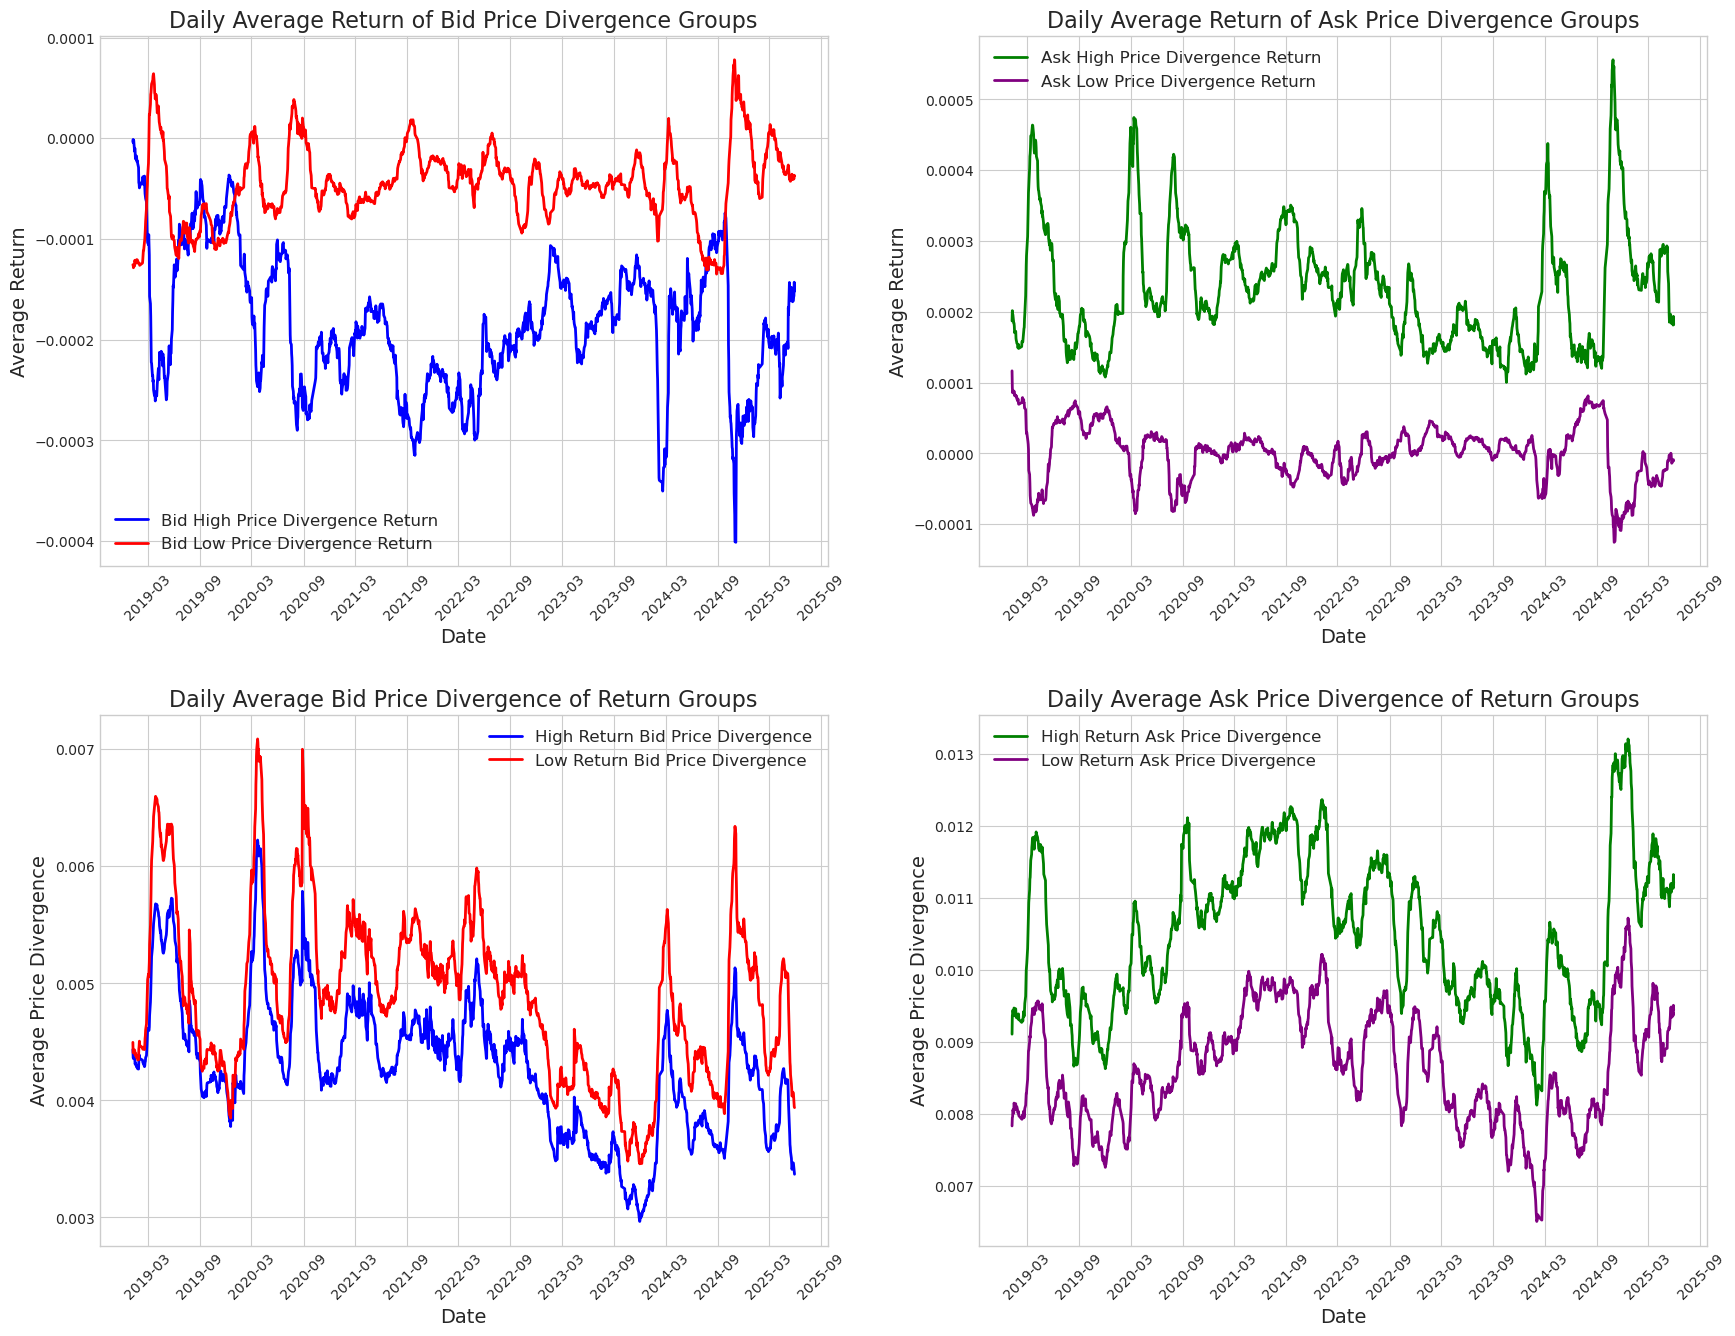

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import numpy as np
from datetime import datetime


# 读取保存的结果数据
input_path = "/data/home/lexuanchen/Factors/Order/Signal/Grid_Group_Percent_Price_Divergence_AND_Minret"
result_df = pd.read_csv(f'{input_path}/All_Grid_Group_Percent_Price_Divergence_AND_Minret.csv')

# 定义因子列表
factors = [
    'bid_high_price_ret',
    'bid_low_price_ret',
    'bid_high_min_price',
    'bid_low_min_price',
    'ask_high_price_ret',
    'ask_low_price_ret',
    'ask_high_min_price',
    'ask_low_min_price'
]

# 确保所有因子列都存在
for factor in factors:
    if factor not in result_df.columns:
        print(f"警告: 列 '{factor}' 不在数据框中")

# 计算每个日期每个因子的均值
result_df['date'] = pd.to_datetime(result_df['date'])
daily_means = result_df.groupby('date')[factors].mean().reset_index()

# 创建图表保存目录
output_path = f"{input_path}/Charts"
os.makedirs(output_path, exist_ok=True)

# 设置图形风格
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(2, 2, figsize=(18, 14))

# 图1: bid_high_price_ret 和 bid_low_price_ret (买盘价格离散度与收益率关系)
axs[0, 0].plot(daily_means['date'], daily_means['bid_high_price_ret'], label='Bid High Price Divergence Return', color='blue', linewidth=2)
axs[0, 0].plot(daily_means['date'], daily_means['bid_low_price_ret'], label='Bid Low Price Divergence Return', color='red', linewidth=2)

# 设置x轴日期格式，每半年显示一次
axs[0, 0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axs[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axs[0, 0].tick_params(axis='x', rotation=45)
axs[0, 0].set_title('Daily Average Return of Bid Price Divergence Groups', fontsize=16)
axs[0, 0].set_xlabel('Date', fontsize=14)
axs[0, 0].set_ylabel('Average Return', fontsize=14)
axs[0, 0].legend(fontsize=12)
axs[0, 0].grid(True)

# 图2: ask_high_price_ret 和 ask_low_price_ret (卖盘价格离散度与收益率关系)
axs[0, 1].plot(daily_means['date'], daily_means['ask_high_price_ret'], label='Ask High Price Divergence Return', color='green', linewidth=2)
axs[0, 1].plot(daily_means['date'], daily_means['ask_low_price_ret'], label='Ask Low Price Divergence Return', color='purple', linewidth=2)

# 设置x轴日期格式，每半年显示一次
axs[0, 1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axs[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axs[0, 1].tick_params(axis='x', rotation=45)
axs[0, 1].set_title('Daily Average Return of Ask Price Divergence Groups', fontsize=16)
axs[0, 1].set_xlabel('Date', fontsize=14)
axs[0, 1].set_ylabel('Average Return', fontsize=14)
axs[0, 1].legend(fontsize=12)
axs[0, 1].grid(True)

# 图3: bid_high_min_price 和 bid_low_min_price (分钟收益率与买盘价格离散度关系)
axs[1, 0].plot(daily_means['date'], daily_means['bid_high_min_price'], label='High Return Bid Price Divergence', color='blue', linewidth=2)
axs[1, 0].plot(daily_means['date'], daily_means['bid_low_min_price'], label='Low Return Bid Price Divergence', color='red', linewidth=2)

# 设置x轴日期格式，每半年显示一次
axs[1, 0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axs[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axs[1, 0].tick_params(axis='x', rotation=45)
axs[1, 0].set_title('Daily Average Bid Price Divergence of Return Groups', fontsize=16)
axs[1, 0].set_xlabel('Date', fontsize=14)
axs[1, 0].set_ylabel('Average Price Divergence', fontsize=14)
axs[1, 0].legend(fontsize=12)
axs[1, 0].grid(True)

# 图4: ask_high_min_price 和 ask_low_min_price (分钟收益率与卖盘价格离散度关系)
axs[1, 1].plot(daily_means['date'], daily_means['ask_high_min_price'], label='High Return Ask Price Divergence', color='green', linewidth=2)
axs[1, 1].plot(daily_means['date'], daily_means['ask_low_min_price'], label='Low Return Ask Price Divergence', color='purple', linewidth=2)

# 设置x轴日期格式，每半年显示一次
axs[1, 1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axs[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axs[1, 1].tick_params(axis='x', rotation=45)
axs[1, 1].set_title('Daily Average Ask Price Divergence of Return Groups', fontsize=16)
axs[1, 1].set_xlabel('Date', fontsize=14)
axs[1, 1].set_ylabel('Average Price Divergence', fontsize=14)
axs[1, 1].legend(fontsize=12)
axs[1, 1].grid(True)

# 调整布局，确保图表不重叠
plt.tight_layout(pad=3.0)

# 保存整个图表
# plt.savefig(f'{output_path}/all_price_divergence_analysis.png', dpi=300, bbox_inches='tight')

plt.show()

# plt.close()

# print(f"所有图表已保存到 {output_path} 目录")



In [3]:
# 读取保存的结果数据
input_path = "/data/home/lexuanchen/Factors/Order/Signal/Grid_Group_Percent_Price_Divergence_AND_Minret"
result_df = pd.read_csv(f'{input_path}/All_Grid_Group_Percent_Price_Divergence_AND_Minret.csv')

# 定义因子列表
factors = [
    'bid_high_price_ret',
    'bid_low_price_ret',
    'bid_high_min_price',
    'bid_low_min_price',
    'ask_high_price_ret',
    'ask_low_price_ret',
    'ask_high_min_price',
    'ask_low_min_price'
]

result_df.head()

,Unnamed: 0,date,security_code,bid_high_price_ret,bid_low_price_ret,bid_high_min_price,bid_low_min_price,ask_high_price_ret,ask_low_price_ret,ask_high_min_price,ask_low_min_price
0,0,2019-01-02,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-01-02,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2019-01-02,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2019-01-02,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2019-01-02,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
for factor in factors:

    df = result_df[['date','security_code',factor]].copy()

    df.to_csv(f"{input_path}/20d_{factor}.csv")

In [8]:
from tqdm import tqdm  # 导入函数而不是模块


minute_dir = "./factors/Grid_Group_Percent_Price_Divergence_AND_Minret"

parquet_pattern = os.path.join(minute_dir, "*.parquet")
parquet_files = glob.glob(parquet_pattern)

dfs = []
for file in tqdm(parquet_files, desc="读取parquet文件"):
    df = pd.read_parquet(file)
    dfs.append(df)

# 合并所有数据框
combined_df = pd.concat(dfs, ignore_index=True)
print(f"合并后的数据形状: {combined_df.shape}")


读取parquet文件: 100%|██████████| 1553/1553 [01:01<00:00, 25.22it/s]


合并后的数据形状: (6974552, 10)


In [9]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6974552 entries, 0 to 6974551
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   security_code       object 
 1   date                object 
 2   bid_high_price_ret  float64
 3   bid_low_price_ret   float64
 4   bid_high_min_price  float64
 5   bid_low_min_price   float64
 6   ask_high_price_ret  float64
 7   ask_low_price_ret   float64
 8   ask_high_min_price  float64
 9   ask_low_min_price   float64
dtypes: float64(8), object(2)
memory usage: 532.1+ MB


In [10]:
for factor in factors:

    df = combined_df[['date','security_code', factor]].copy()

    df.to_csv(f"{input_path}/Raw_{factor}.csv")

In [2]:
file = "/data/home/lexuanchen/.conda/envs/Order_Improvement/factors/Minute_Ret_and_Minute_Percent_Order_Price_Divergence/20190107.parquet"

df = pd.read_parquet(file)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886867 entries, 0 to 886866
Data columns (total 6 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   trading_day                  886867 non-null  datetime64[ns]
 1   security_code                886867 non-null  object        
 2   start_time                   886867 non-null  int64         
 3   bid_price_divergence_p01p99  858489 non-null  float64       
 4   ask_price_divergence_p01p99  858512 non-null  float64       
 5   minute_return                842061 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 40.6+ MB


In [ ]:
# import pandas as pd
# import numpy as np
# import os

factor_dir ="./factors/Minute_Ret_and_Minute_Percent_Order_Price_Divergence"

parquet_pattern = os.path.join(factor_dir, "*.parquet")
parquet_files = glob.glob(parquet_pattern)
print(f"在目录 {factor_dir} 中找到 {len(parquet_files)} 个Parquet文件")


conn = duckdb.connect(database=':memory:')
combined_df = conn.execute(f"""
    SELECT * FROM read_parquet('{parquet_pattern}')
""").fetchdf()
conn.close()



# 假设数据框名为combined_df
# 1. 计算整体相关性
overall_correlation = combined_df['bid_price_divergence_p01p99'].corr(combined_df['minute_return'])
print(f"整体相关性: {overall_correlation}")

# 2. 计算每天每只股票的相关性
print("开始计算每天每只股票的相关性...")

# 内存优化版本 - 逐日处理
all_correlations = []

# 获取唯一的交易日列表

unique_days = combined_df['trading_day'].unique()
total_days = len(unique_days)

for i, day in enumerate(unique_days):
    if i % 10 == 0:  # 每处理10天打印一次进度
        print(f"处理进度: {i}/{total_days} 天")
    
    # 只加载当天的数据
    day_data = combined_df[combined_df['trading_day'] == day]
    
    # 按股票代码分组计算相关性
    day_correlations = day_data.groupby('security_code').apply(
        lambda x: x['bid_price_divergence_p01p99'].corr(x['minute_return']) if len(x) > 1 else np.nan
    ).reset_index(name='correlation')
    
    # 添加交易日列
    day_correlations['trading_day'] = day
    
    # 添加到结果列表
    all_correlations.append(day_correlations)
    
    # 清理内存
    del day_data
    
print("所有日期处理完毕，正在合并结果...")

# 合并所有结果
correlations = pd.concat(all_correlations, ignore_index=True)

# 重新排列列顺序
correlations = correlations[['trading_day', 'security_code', 'correlation']]

# 移除NaN值
correlations = correlations.dropna()

# 保存结果
output_path = "/data/home/lexuanchen/Factors/Order/Signal/Raw_Corr_Min_Percent_Bid_Price_Divergence_AND_Minret.csv"
correlations.to_csv(output_path, index=False)

print(f"结果已保存到: {output_path}")

# 显示一些基本统计信息
print("\n相关性统计信息:")
print(correlations['correlation'].describe())

# 检查极端值
print("\n相关性极端值:")
print("最大正相关:", correlations.nlargest(5, 'correlation')[['trading_day', 'security_code', 'correlation']])
print("最大负相关:", correlations.nsmallest(5, 'correlation')[['trading_day', 'security_code', 'correlation']])

# 检查每天的平均相关性趋势
daily_avg_corr = correlations.groupby('trading_day')['correlation'].mean().reset_index()
print("\n每日平均相关性 (前5天和后5天):")
print("前5天:")
print(daily_avg_corr.head(20))
print("后5天:")
print(daily_avg_corr.tail(20))

# 确认文件已成功保存
if os.path.exists(output_path):
   
    print(f"\n文件已成功保存")
else:
    print("\n警告：文件可能未成功保存！")


整体相关性: -0.014331000772016924
开始计算每天每只股票的相关性...
处理进度: 0/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 10/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 20/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 30/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 40/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 50/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 60/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 70/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 80/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 90/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 100/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 110/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 120/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 130/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 140/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 150/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 160/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 170/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 180/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 190/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 200/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 210/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 220/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 230/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 240/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 250/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 260/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 270/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 280/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 290/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 300/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 310/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 320/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 330/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 340/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 350/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 360/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 370/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 380/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 390/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 400/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 410/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 420/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 430/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 440/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 450/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 460/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 470/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 480/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 490/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 500/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 510/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 520/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 530/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 540/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 550/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 560/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 570/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 580/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 590/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 600/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 610/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 620/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 630/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 640/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 650/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 660/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 670/1553 天


/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the groupin

处理进度: 680/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 690/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 700/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 710/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 720/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 730/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 740/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 750/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 760/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 770/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 780/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 790/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 800/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 810/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 820/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 830/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 840/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 850/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 860/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 870/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 880/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 890/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 900/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 910/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 920/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 930/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 940/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 950/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 960/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 970/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 980/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 990/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1000/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1010/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1020/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1030/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1040/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1050/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1060/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1070/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1080/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1090/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1100/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1110/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1120/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1130/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1140/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1150/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1160/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1170/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1180/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1190/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1200/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1210/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1220/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1230/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1240/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1250/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1260/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1270/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1280/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1290/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1300/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1310/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1320/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1330/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1340/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1350/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1360/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1370/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1380/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1390/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1400/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1410/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1420/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1430/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1440/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1450/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1460/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1470/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1480/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1490/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1500/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1510/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1520/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1530/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1540/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

处理进度: 1550/1553 天


/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_1684984/1964535804.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_correlations = day_data.groupby('security_code').apply(
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/hom

所有日期处理完毕，正在合并结果...
结果已保存到: /data/home/lexuanchen/Factors/Order/Signal/Raw_Corr_Min_Percent_Bid_Price_Divergence_AND_Minret.csv

相关性统计信息:
count    6.950606e+06
mean    -4.816239e-02
std      8.836355e-02
min     -1.000000e+00
25%     -1.039873e-01
50%     -4.755307e-02
75%      7.670323e-03
max      1.000000e+00
Name: correlation, dtype: float64

相关性极端值:
最大正相关:         trading_day security_code  correlation
3791752  2024-05-13        600289     1.000000
3968006  2024-07-01        000609     0.990738
6398540  2022-08-22        000670     0.972710
6353881  2025-05-06        002231     0.955803
884094   2024-05-06        600715     0.930119
最大负相关:        trading_day security_code  correlation
93061   2024-06-25        002742         -1.0
316246  2020-09-03        603155         -1.0
329391  2023-09-11        603221         -1.0
343522  2023-06-01        600589         -1.0
438796  2023-10-19        600759         -1.0

每日平均相关性 (前5天和后5天):
前5天:
   trading_day  correlation
0   2019-01-02    -

In [2]:
factor_dir ="./factors/Minute_Ret_and_Minute_Percent_Order_Price_Divergence"

parquet_pattern = os.path.join(factor_dir, "*.parquet")
parquet_files = glob.glob(parquet_pattern)
print(f"在目录 {factor_dir} 中找到 {len(parquet_files)} 个Parquet文件")


conn = duckdb.connect(database=':memory:')
combined_df = conn.execute(f"""
    SELECT * FROM read_parquet('{parquet_pattern}')
""").fetchdf()
conn.close()



# 假设数据框名为combined_df
# 1. 计算整体相关性
overall_correlation = combined_df['bid_price_divergence_p01p99'].corr(combined_df['ask_price_divergence_p01p99'])
print(f"买卖方分钟分歧度整体相关性: {overall_correlation}")

在目录 ./factors/Minute_Ret_and_Minute_Percent_Order_Price_Divergence 中找到 1553 个Parquet文件


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

买卖方分钟分歧度整体相关性: 0.1436857749411973


In [7]:
file_path = "/data/home/lexuanchen/Factors/Order/Signal/Raw_Corr_Min_Percent_Bid_Price_Divergence_AND_Minret.csv"

all_factor_data = pd.read_csv(file_path)

factor_names = ['correlation']

all_securities = all_factor_data['security_code'].unique()

# result_df = all_factor_data[['date', 'security_code']].copy()

for factor_name in factor_names:
    print(f"\n处理因子: {factor_name}")
    
    #转置成宽表
    pivot_data = all_factor_data.pivot(index='trading_day', columns='security_code', values=factor_name)

    # 对宽表直接应用rolling
    rolling_avg = pivot_data.rolling(window=20, min_periods=5).mean()

    # 将结果转换回长格式
    factor_df = rolling_avg.stack().reset_index()
    factor_df.columns = ['trading_day', 'security_code', factor_name]

    # 计算每日因子覆盖率
    # 计算每个日期非NaN的因子值数量
    non_nan_counts = factor_df.dropna(subset=[factor_name]).groupby('trading_day').size()

    # 计算覆盖率
    coverage = non_nan_counts / len(all_securities)
    print(f"\n{factor_name}因子覆盖率统计: 平均={coverage.mean():.2f}, 最小={coverage.min():.2f}")

    # result_df = pd.merge(
    #     result_df, 
    #     factor_df,
    #     on=['trading_day', 'security_code'],
    #     how='left'
    # )

output_path = "/data/home/lexuanchen/Factors/Order/Signal/20d_Corr_Min_Percent_Bid_Price_Divergence_AND_Minret.csv"

factor_df.to_csv(output_path)



处理因子: correlation

correlation因子覆盖率统计: 平均=0.84, 最小=0.66
